# Exploring and Clustering

> In this part, In this part, the study, transformation and analysis of data is carried out.

## 1. Methodology

In this project we will direct our efforts on detecting information about areas of Penza. We restrict our analysis to the city and nearby settlements. 

In the previous step we have collected the required data: location and information of every apartment that is available for long-term rent and on the **Cyan** website. We also got vanues data with **Foursquare API** and transformed it **using one hot encoding**.

At the moment we have to identify Districts (according to Foursquare categorization). Based on the data received, we will split our ads into clusters using the **k-means Clustering**.

In the analytical part we will analze results.

## 2. Import Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import re

from geopy.geocoders import Nominatim

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline 

import folium

from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

## 3. Explore data

In [2]:
df_Penza = pd.read_csv("df_Penza.csv")
penza_grouped_by_microDistrict = pd.read_csv("penza_grouped_by_microDistrict.csv")
neighborhoods_venues_sorted_microDistrict = pd.read_csv("neighborhoods_venues_sorted_microDistrict.csv")

## 4. Cluster Districts

In [3]:
kclusters = 4

In [4]:
penza_grouped_by_microDistrict_clustering = penza_grouped_by_microDistrict.drop('microDistrict', 1)

In [5]:
kmeans_by_microDistrict = KMeans(init = "k-means++", n_clusters=kclusters, random_state=0, n_init = 1000).fit(penza_grouped_by_microDistrict_clustering)

In [6]:
neighborhoods_venues_sorted_microDistrict.insert(0, 'Cluster Labels', kmeans_by_microDistrict.labels_)

In [7]:
penza_merged = df_Penza

In [8]:
penza_merged = penza_merged.join(neighborhoods_venues_sorted_microDistrict.set_index('microDistrict'), on='microDistrict')
penza_merged.dropna(subset=['Cluster Labels'], axis=0, inplace=True)
penza_merged.reset_index(drop=True, inplace=True)
penza_merged.head() 

FullAdress             District              Address  \
0  проспект Строителей, 152      р-н Октябрьский  проспект Строителей   
1          улица Ленина, 12      р-н Октябрьский         улица Ленина   
2     Рахманинова проезд, 5      р-н Октябрьский   Рахманинова проезд   
3   улица Терновского, 158Б     р-н Первомайский    улица Терновского   
4    улица Володарского, 75  р-н Железнодорожный   улица Володарского   

   NumRooms  Area  Floor                                        Description  \
0       3.0  64.0    4.0  Сдам 3-х ком. квартиру на длительный срок по п...   
1       3.0  70.0    1.0  Большая 3х комнатная квартира 70м2,в шикарном ...   
2       1.0  30.0    3.0  Сдается современная 1 ком квартира в развитом ...   
3       1.0  40.0    9.0  11 000 + ком.плат + 600 руб Инет и Тв (подключ...   
4       2.0  62.0    2.0  Сдается 2 ком кв на Володарского 75. Сдаётся д...   

   MonthlyPayments  OneTimeFee microDistrict  ALatitude  ALongitude  \
0             15.0         5.5     Запрудный  53.220538   44.888742   
1             15.0         5.0     Заводской  53.215607   45.000883   
2             15.0         5.5      Арбеково  53.225680   44.929247   
3             15.0         8.5      Терновка  53.144821   45.024579   
4             15.0         5.5         Центр  53.200063   45.016249   

    Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0  53.172801  44.973169             2.0         Shopping Mall   
1  53.172801  44.973169             2.0         Shopping Mall   
2  53.172801  44.973169             2.0         Shopping Mall   
3  53.162396  45.029846             0.0     Convenience Store   
4  53.203561  45.012268             3.0            Restaurant   

  2nd Most Common Venue 3rd Most Common Venue        4th Most Common Venue  \
0         Grocery Store          Liquor Store            Food & Drink Shop   
1         Grocery Store          Liquor Store            Food & Drink Shop   
2         Grocery Store          Liquor Store            Food & Drink Shop   
3            Restaurant     Food & Drink Shop  Eastern European Restaurant   
4                  Café         Shopping Mall             Sushi Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0             Wine Shop        Cosmetics Shop  Gym / Fitness Center   
1             Wine Shop        Cosmetics Shop  Gym / Fitness Center   
2             Wine Shop        Cosmetics Shop  Gym / Fitness Center   
3                 Hotel                   Bar             Bookstore   
4                   Bar     Electronics Store               Theater   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0     German Restaurant           Gaming Cafe      French Restaurant  
1     German Restaurant           Gaming Cafe      French Restaurant  
2     German Restaurant           Gaming Cafe      French Restaurant  
3            Hookah Bar  Gym / Fitness Center          Grocery Store  
4   Sporting Goods Shop           Coffee Shop                  Plaza

In [9]:
penza_merged['Cluster Labels'].value_counts()

3.0    124
2.0    119
0.0     97
1.0     75
Name: Cluster Labels, dtype: int64

In [10]:
address = 'Penza'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Penza are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Penza are 53.200001, 45.0.


In [11]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x) for i in range(kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(penza_merged['ALatitude'], penza_merged['ALongitude'], penza_merged['FullAdress'], penza_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

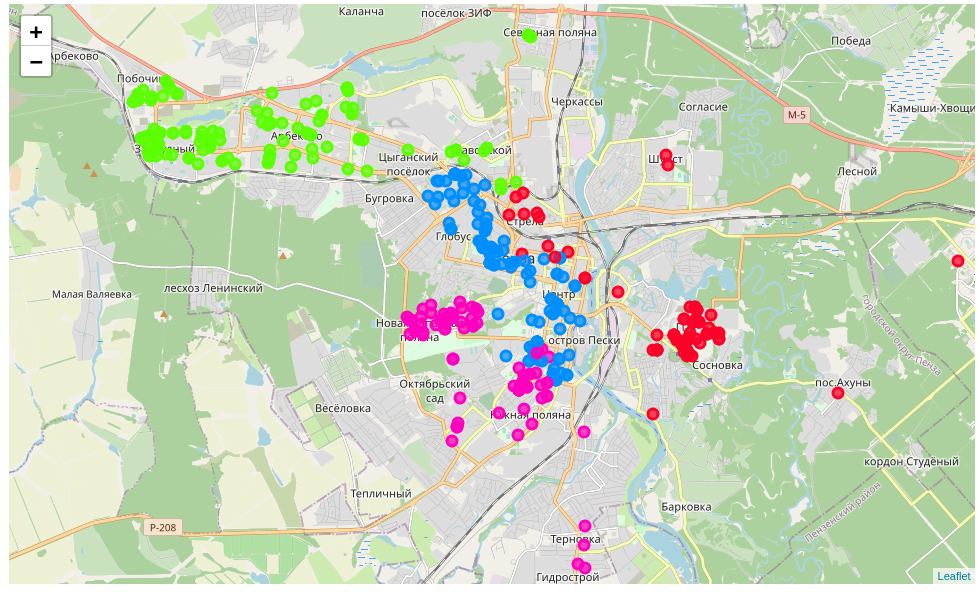

## 5. Analyze

In [12]:
penza_merged.corr()['Cluster Labels']

NumRooms           0.018771
Area               0.022183
Floor              0.002739
MonthlyPayments   -0.006770
OneTimeFee         0.000119
ALatitude          0.455843
ALongitude        -0.168820
Latitude           0.430865
Longitude         -0.275619
Cluster Labels     1.000000
Name: Cluster Labels, dtype: float64

We have a weak correlation with respect to the clusters obtained from the indicators of apartments. 

Therefore, when choosing an apartment, we can be guided by the area in which it is located.

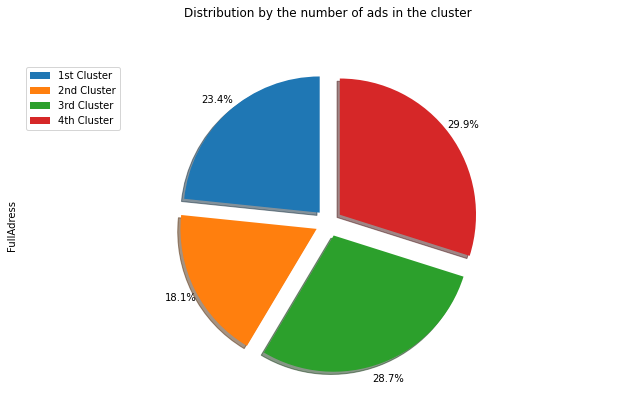

In [13]:
df_Penza_clusters = penza_merged.groupby(['Cluster Labels']).count().reset_index()
explode_list = [0.1, 0.1, 0.1, 0.1]

df_Penza_clusters['FullAdress'].plot(kind='pie',
                            figsize=(11, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,                 
                            pctdistance=1.12,            
                            explode=explode_list         
                            )


plt.title('Distribution by the number of ads in the cluster', y=1.12)
plt.axis('equal') 

labels = df_Penza_clusters.index.map({0: '1st Cluster', 1: '2nd Cluster', 2: '3rd Cluster', 3: '4th Cluster'})
plt.legend(labels=labels, loc='upper left') 

# show plot
plt.show()

___
Functions for obtaining detailed information on clusters:

In [14]:
def mean_payment(cl):
    print('The mean payment per month = {:.1f}thousand rubles + one time fee = {:.1f}thousand rubles'.format(cl.MonthlyPayments.mean(), cl.OneTimeFee.mean()))

In [15]:
def create_map(cl):
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
    kclusters = 4
    
    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(cl['ALatitude'], cl['ALongitude'], cl['FullAdress'], cl['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        cluster = int(cluster)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

In [16]:
def top_vanues(cl):
    print('------------------------------------')
    print('1st Most Common Venue(s) in District')
    print(', '.join(cl['1st Most Common Venue'].unique()))
    print('------------------------------------')
    print('2nd Most Common Venue(s) in District')
    print(', '.join(cl['2nd Most Common Venue'].unique()))
    print('------------------------------------')
    print('3rd Most Common Venue(s) in District')
    print(', '.join(cl['3rd Most Common Venue'].unique()))
    print('------------------------------------')
    print('4th Most Common Venue(s) in District')
    print(', '.join(cl['4th Most Common Venue'].unique()))
    print('------------------------------------')
    print('5th Most Common Venue(s) in District')
    print(', '.join(cl['5th Most Common Venue'].unique()))
    print('------------------------------------')
    print('6th Most Common Venue(s) in District')
    print(', '.join(cl['6th Most Common Venue'].unique()))
    print('------------------------------------')
    print('7th Most Common Venue(s) in District')
    print(', '.join(cl['7th Most Common Venue'].unique()))
    print('------------------------------------')
    print('8th Most Common Venue(s) in District')
    print(', '.join(cl['8th Most Common Venue'].unique()))
    print('------------------------------------')
    print('9th Most Common Venue(s) in District')
    print(', '.join(cl['9th Most Common Venue'].unique()))
    print('------------------------------------')
    print('10th Most Common Venue(s) in District')
    print(', '.join(cl['10th Most Common Venue'].unique()))
    print('------------------------------------')

In [17]:
def values(cl):
    print('Mean floor')
    print('{:.0f}'.format(cl['Floor'].mean()))
    print('Mean area')
    print('{:.0f}'.format(cl['Area'].mean()))
    print('Mean rooms')
    print('{:.0f}'.format(cl['NumRooms'].mean()))

In [18]:
def coast(cl):
    print('On average in terms of money, the apartment will be released:')
    print('with 1 room')
    print('{:.1f} thousand rubles'.format(cl.loc[cl.loc[:, 'NumRooms'] == 1.0]['MonthlyPayments'].mean()))
    print('with 2 room')
    print('{:.1f} thousand rubles'.format(cl.loc[cl.loc[:, 'NumRooms'] == 2.0]['MonthlyPayments'].mean()))
    print('with 3 room')
    print('{:.1f} thousand rubles'.format(cl.loc[cl.loc[:, 'NumRooms'] == 3.0]['MonthlyPayments'].mean()))

___

### First Cluster

In [19]:
cl_penza1 = penza_merged.loc[penza_merged['Cluster Labels'] == 0, penza_merged.columns]
cl_penza1.head()

FullAdress          District            Address  NumRooms  \
3   улица Терновского, 158Б  р-н Первомайский  улица Терновского       1.0   
11       улица Калинина, 80  р-н Первомайский     улица Калинина       2.0   
16      улица Богданова, 54  р-н Первомайский    улица Богданова       2.0   
19      улица Калинина, 123  р-н Первомайский     улица Калинина       2.0   
25     улица Кижеватова, 19  р-н Первомайский   улица Кижеватова       1.0   

    Area  Floor                                        Description  \
3   40.0    9.0  11 000 + ком.плат + 600 руб Инет и Тв (подключ...   
11  43.0    3.0  Квартира уютная, во дворе детская плашкоута и ...   
16  62.0    3.0  хороший район все рядом до центра 15 мин пешко...   
19  45.0    7.0  Сдам чистую, светлую, уютную, теплую двухкомна...   
25  48.0    2.0         Все необходимое для комфортного проживания   

    MonthlyPayments  OneTimeFee microDistrict  ALatitude  ALongitude  \
3              15.0         8.5      Терновка  53.144821   45.024579   
11             15.0         5.0  Южная поляна  53.171684   45.011670   
16             16.0         6.0  Южная поляна  53.173873   45.009614   
19             16.0         6.0  Южная поляна  53.163651   45.001802   
25             14.0         5.0  Южная поляна  53.165369   44.980927   

     Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
3   53.162396  45.029846             0.0     Convenience Store   
11  53.162396  45.029846             0.0     Convenience Store   
16  53.162396  45.029846             0.0     Convenience Store   
19  53.162396  45.029846             0.0     Convenience Store   
25  53.162396  45.029846             0.0     Convenience Store   

   2nd Most Common Venue 3rd Most Common Venue        4th Most Common Venue  \
3             Restaurant     Food & Drink Shop  Eastern European Restaurant   
11            Restaurant     Food & Drink Shop  Eastern European Restaurant   
16            Restaurant     Food & Drink Shop  Eastern European Restaurant   
19            Restaurant     Food & Drink Shop  Eastern European Restaurant   
25            Restaurant     Food & Drink Shop  Eastern European Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
3                  Hotel                   Bar             Bookstore   
11                 Hotel                   Bar             Bookstore   
16                 Hotel                   Bar             Bookstore   
19                 Hotel                   Bar             Bookstore   
25                 Hotel                   Bar             Bookstore   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
3             Hookah Bar  Gym / Fitness Center          Grocery Store  
11            Hookah Bar  Gym / Fitness Center          Grocery Store  
16            Hookah Bar  Gym / Fitness Center          Grocery Store  
19            Hookah Bar  Gym / Fitness Center          Grocery Store  
25            Hookah Bar  Gym / Fitness Center          Grocery Store

In [20]:
create_map(cl_penza1)

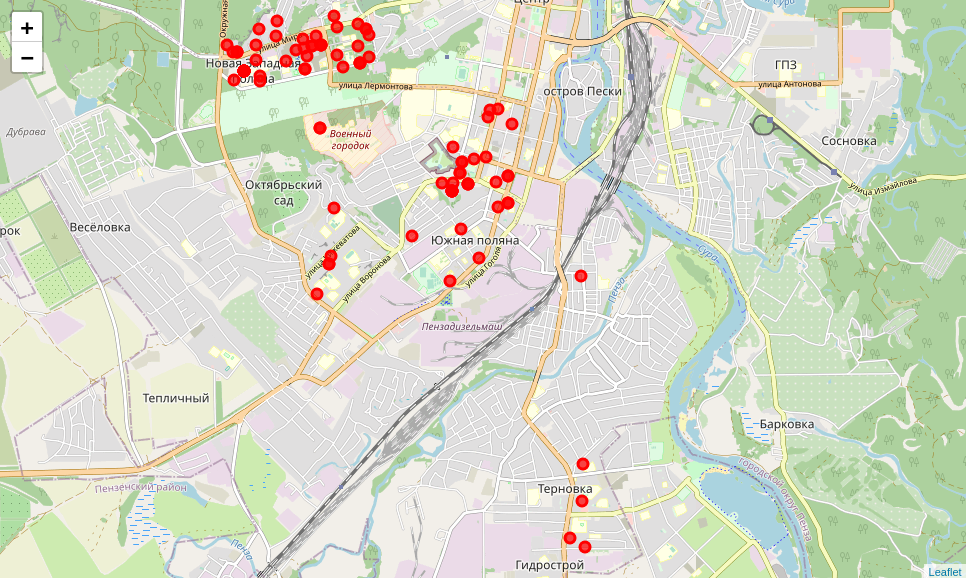

In [21]:
mean_payment(cl_penza1)

The mean payment per month = 13.8thousand rubles + one time fee = 5.2thousand rubles


In [22]:
top_vanues(cl_penza1)

------------------------------------
1st Most Common Venue(s) in District
Convenience Store
------------------------------------
2nd Most Common Venue(s) in District
Restaurant
------------------------------------
3rd Most Common Venue(s) in District
Food & Drink Shop
------------------------------------
4th Most Common Venue(s) in District
Eastern European Restaurant
------------------------------------
5th Most Common Venue(s) in District
Hotel
------------------------------------
6th Most Common Venue(s) in District
Bar
------------------------------------
7th Most Common Venue(s) in District
Bookstore
------------------------------------
8th Most Common Venue(s) in District
Hookah Bar
------------------------------------
9th Most Common Venue(s) in District
Gym / Fitness Center
------------------------------------
10th Most Common Venue(s) in District
Grocery Store
------------------------------------


In [23]:
values(cl_penza1)

Mean floor
5
Mean area
40
Mean rooms
1


In [24]:
coast(cl_penza1)

On average in terms of money, the apartment will be released:
with 1 room
13.3 thousand rubles
with 2 room
15.9 thousand rubles
with 3 room
14.0 thousand rubles


___

### Second Cluster

In [25]:
cl_penza2 = penza_merged.loc[penza_merged['Cluster Labels'] == 1, penza_merged.columns]

In [26]:
create_map(cl_penza2)

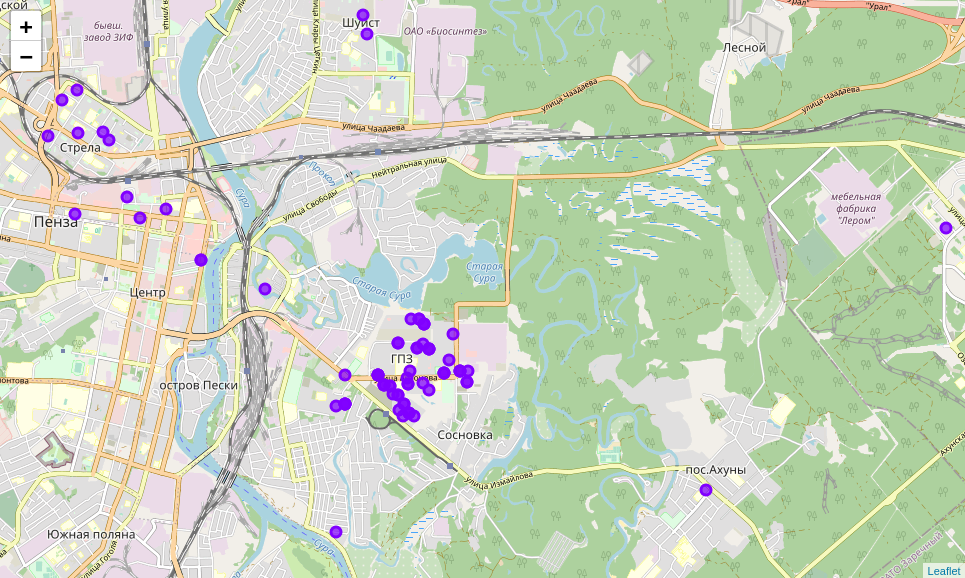

In [27]:
mean_payment(cl_penza2)

The mean payment per month = 13.5thousand rubles + one time fee = 4.6thousand rubles


In [28]:
top_vanues(cl_penza2)

------------------------------------
1st Most Common Venue(s) in District
Restaurant, Café
------------------------------------
2nd Most Common Venue(s) in District
Café, Restaurant
------------------------------------
3rd Most Common Venue(s) in District
Sushi Restaurant
------------------------------------
4th Most Common Venue(s) in District
Electronics Store
------------------------------------
5th Most Common Venue(s) in District
Nightclub
------------------------------------
6th Most Common Venue(s) in District
Food & Drink Shop, Shopping Mall
------------------------------------
7th Most Common Venue(s) in District
Bar
------------------------------------
8th Most Common Venue(s) in District
Shopping Mall, Theater
------------------------------------
9th Most Common Venue(s) in District
Sporting Goods Shop
------------------------------------
10th Most Common Venue(s) in District
Supermarket, Food & Drink Shop
------------------------------------


In [29]:
values(cl_penza2)

Mean floor
6
Mean area
46
Mean rooms
2


In [30]:
coast(cl_penza2)

On average in terms of money, the apartment will be released:
with 1 room
12.0 thousand rubles
with 2 room
14.9 thousand rubles
with 3 room
16.1 thousand rubles


___

### Third Cluster

In [31]:
cl_penza3 = penza_merged.loc[penza_merged['Cluster Labels'] == 2, penza_merged.columns]

In [32]:
create_map(cl_penza3)

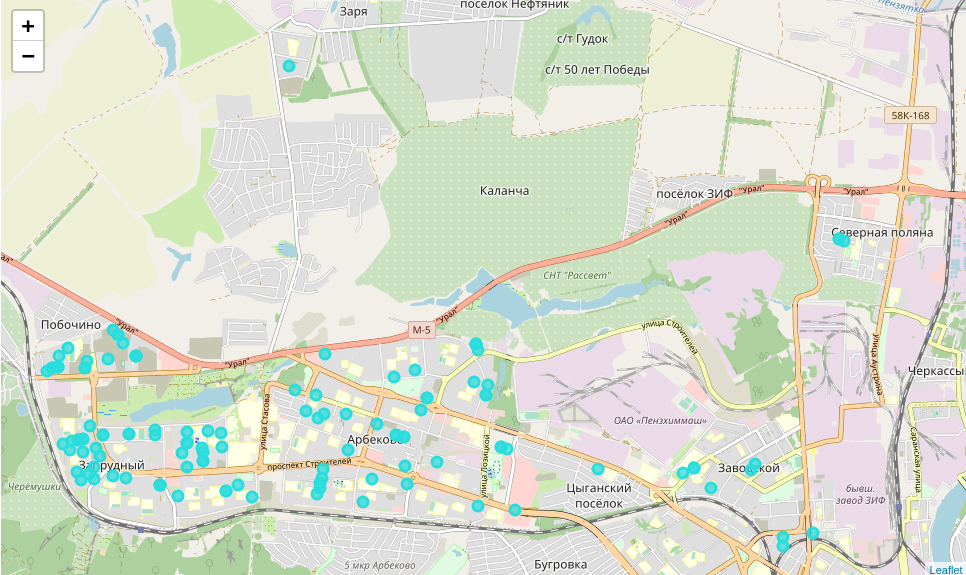

In [33]:
mean_payment(cl_penza3)

The mean payment per month = 13.1thousand rubles + one time fee = 4.9thousand rubles


In [34]:
top_vanues(cl_penza3)

------------------------------------
1st Most Common Venue(s) in District
Shopping Mall
------------------------------------
2nd Most Common Venue(s) in District
Grocery Store
------------------------------------
3rd Most Common Venue(s) in District
Liquor Store
------------------------------------
4th Most Common Venue(s) in District
Food & Drink Shop
------------------------------------
5th Most Common Venue(s) in District
Wine Shop
------------------------------------
6th Most Common Venue(s) in District
Cosmetics Shop
------------------------------------
7th Most Common Venue(s) in District
Gym / Fitness Center
------------------------------------
8th Most Common Venue(s) in District
German Restaurant
------------------------------------
9th Most Common Venue(s) in District
Gaming Cafe
------------------------------------
10th Most Common Venue(s) in District
French Restaurant
------------------------------------


In [35]:
values(cl_penza3)

Mean floor
5
Mean area
42
Mean rooms
1


In [36]:
coast(cl_penza3)

On average in terms of money, the apartment will be released:
with 1 room
12.5 thousand rubles
with 2 room
13.8 thousand rubles
with 3 room
16.4 thousand rubles


___

### Fourth Cluster

In [37]:
cl_penza4 = penza_merged.loc[penza_merged['Cluster Labels'] == 3, penza_merged.columns]

In [38]:
create_map(cl_penza4)

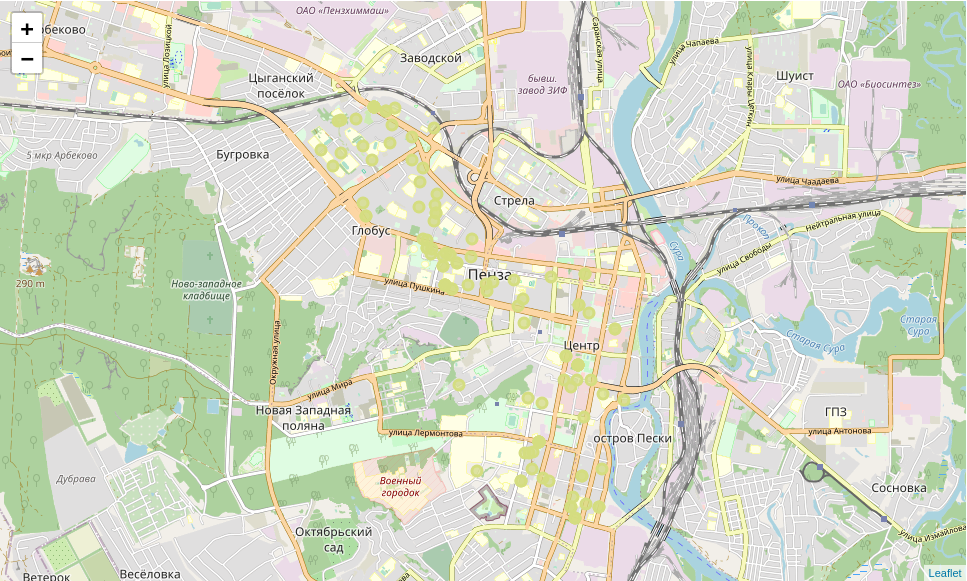

In [39]:
mean_payment(cl_penza4)

The mean payment per month = 13.8thousand rubles + one time fee = 5.1thousand rubles


In [40]:
top_vanues(cl_penza4)

------------------------------------
1st Most Common Venue(s) in District
Restaurant, Café
------------------------------------
2nd Most Common Venue(s) in District
Café, Restaurant
------------------------------------
3rd Most Common Venue(s) in District
Shopping Mall
------------------------------------
4th Most Common Venue(s) in District
Sushi Restaurant
------------------------------------
5th Most Common Venue(s) in District
Bar
------------------------------------
6th Most Common Venue(s) in District
Electronics Store, Plaza
------------------------------------
7th Most Common Venue(s) in District
Theater, Coffee Shop
------------------------------------
8th Most Common Venue(s) in District
Sporting Goods Shop, Coffee Shop
------------------------------------
9th Most Common Venue(s) in District
Coffee Shop, Plaza, Theater
------------------------------------
10th Most Common Venue(s) in District
Plaza, Sporting Goods Shop, Electronics Store, Theater
----------------------------

In [41]:
values(cl_penza4)

Mean floor
5
Mean area
41
Mean rooms
1


In [42]:
coast(cl_penza4)

On average in terms of money, the apartment will be released:
with 1 room
13.5 thousand rubles
with 2 room
14.4 thousand rubles
with 3 room
16.5 thousand rubles


___

Distribution by price:

<AxesSubplot:xlabel='MonthlyPayments', ylabel='microDistrict'>

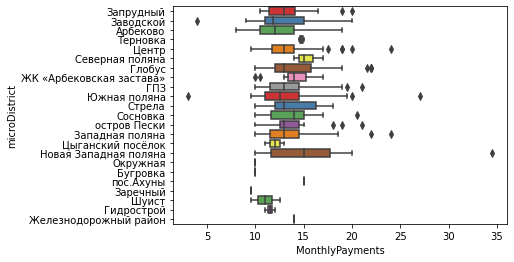

In [43]:
sns.boxplot(x="MonthlyPayments", y="microDistrict", data=df_Penza, orient='h', palette="Set1")

In [44]:
df_Penza = df_Penza.loc[(df_Penza.MonthlyPayments <= 17) & (df_Penza.MonthlyPayments >= 5)]

<AxesSubplot:xlabel='MonthlyPayments', ylabel='microDistrict'>

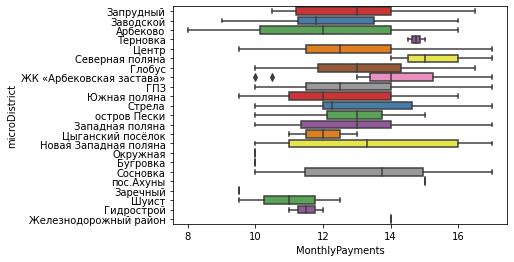

In [45]:
sns.boxplot(x="MonthlyPayments", y="microDistrict", data=df_Penza, orient='h', palette="Set1")